importing modules

In [2]:
import os
import torch
import numpy as np
import tqdm as tqdm
from torchvision import datasets
from torch.utils.data import Dataset,DataLoader


Loading the data from the preprocessed data(MRI BRAIN)

In [ ]:
# def npy_loader(path):
#     sample = torch.from_numpy(np.load(path))
#     return sample

In [ ]:
# Data_dir="Dataset/processed/train/normal"
# nii_files = [f for f in os.listdir(Data_dir) if f.endswith(".npy")]
# for file in tqdm(nii_files, desc="Loading Preprocessed Mri"):
#     data = np.load()
#     dataset = datasets.DatasetFolder(
#     root=os.path.join(Data_dir, file),
#     loader=npy_loader,
#     extensions=['.npy']
# )

In [3]:
class Mridataset(Dataset):
    def __init__(self,dataset_dir):
        self.path=dataset_dir
        self.filenames=[f for f in os.listdir(self.path) if f.endswith(".npy")]
    def __getitem__(self,index):
        tensor_data=torch.from_numpy(np.load(os.path.join(self.path,self.filenames[index])))
        tensor_data=tensor_data.to(torch.float32)
        tensor_data=tensor_data.reshape(1, 128, 128 )
        return tensor_data
    def __len__(self):
        return len(self.filenames)
    



Data loading and visalising

In [4]:
path="../Dataset/processed/train/normal"
dataset=Mridataset(path)


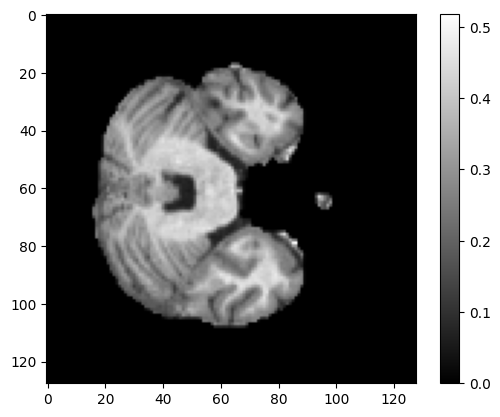

In [5]:
import matplotlib.pyplot as plt

img = dataset[0][0]
plt.imshow(img, cmap="gray")
plt.colorbar()
plt.show()


Loading dataset for feading the gpu effecient to train the data and so onn

In [6]:
dataloader=DataLoader(dataset,batch_size=30,shuffle=True)
dataiterator=iter(dataloader)
batch=next(dataiterator)
print(batch.shape)
print(batch.dtype)

torch.Size([30, 1, 128, 128])
torch.float32


Sanitycheck

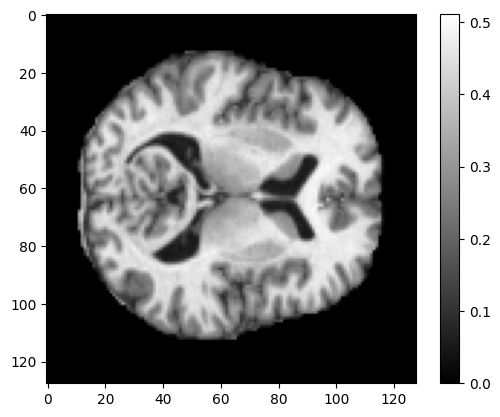

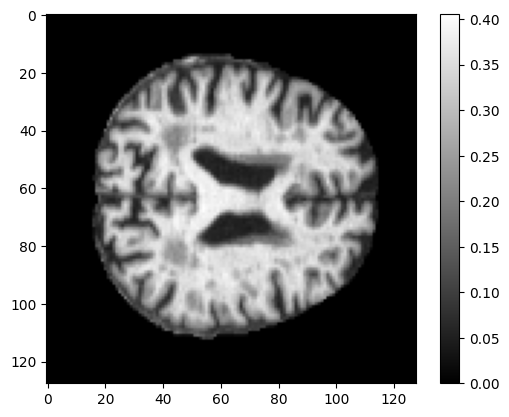

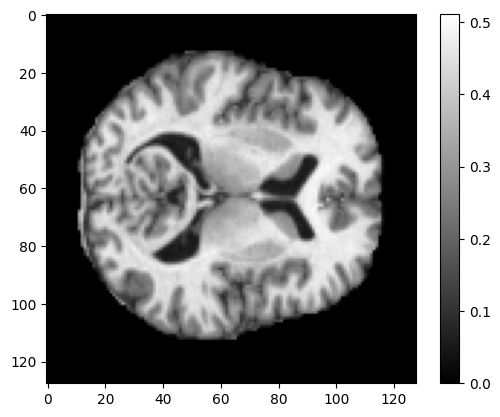

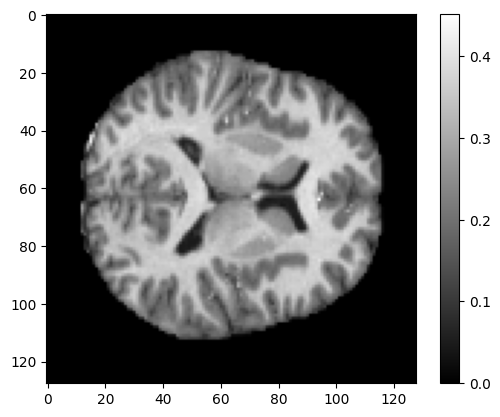

In [7]:
import random
for _ in range(4):
    bn=random.randint(0,29)
    img = batch[bn][0]
    plt.imshow(img, cmap="gray")
    plt.colorbar()
    plt.show()

Make Model

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [9]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # -------- Encoder --------
        self.encoder = nn.Sequential(
            # Input: (B, 1, 128, 128)
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),

            # Downsample → (B, 16, 64, 64)
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),

            # Downsample → (B, 32, 32, 32)
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
        )

        # -------- Decoder --------
        self.decoder = nn.Sequential(
            # Upsample → (B, 64, 64, 64)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),

            # Upsample → (B, 32, 128, 128)
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),

            # Reconstruct → (B, 1, 128, 128)
            nn.Conv2d(16, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


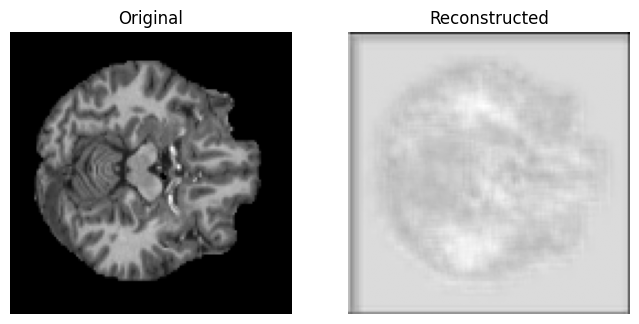

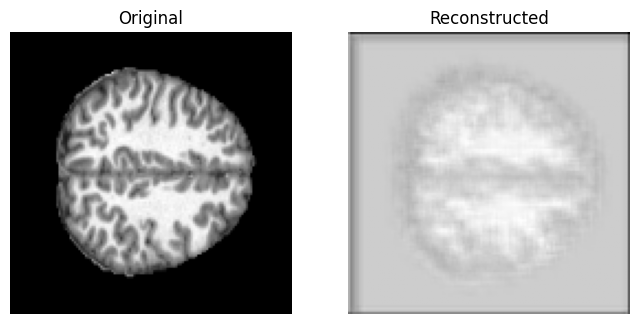

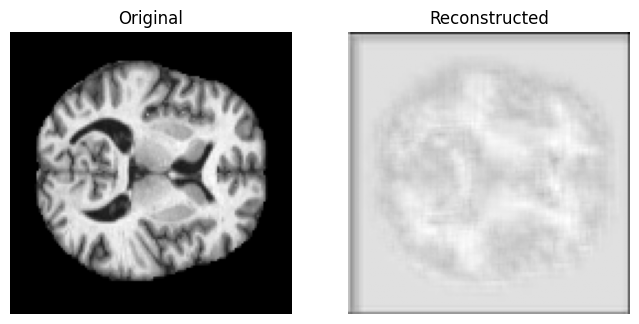

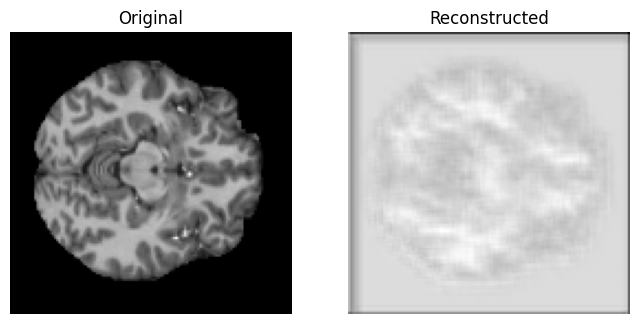

In [10]:
model=Autoencoder()
import random
model.eval()  

with torch.no_grad():  
    recon = model(batch)

for i in range(4):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))

    ax[0].imshow(batch[i][0], cmap="gray")
    ax[0].set_title("Original")
    ax[0].axis("off")

    ax[1].imshow(recon[i][0], cmap="gray")
    ax[1].set_title("Reconstructed")
    ax[1].axis("off")

    plt.show()



Training face

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device being used: {device}")

Device being used: cuda


In [ ]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:

num_epochs = 20   

for epoch in range(num_epochs):
    model.train()  
    running_loss = 0.0

    for batch in dataloader:
        batch = batch.to(device)

        # -------- Forward pass --------
        output = model(batch)
        loss = criterion(output, batch)

        # -------- Backpropagation --------
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(dataloader)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {avg_loss:.6f}")


Epoch [1/20]  Loss: 0.004255
Epoch [2/20]  Loss: 0.000215
Epoch [3/20]  Loss: 0.000172
Epoch [4/20]  Loss: 0.000146
Epoch [5/20]  Loss: 0.000127
Epoch [6/20]  Loss: 0.000116
Epoch [7/20]  Loss: 0.000106
Epoch [8/20]  Loss: 0.000098
Epoch [9/20]  Loss: 0.000091
Epoch [10/20]  Loss: 0.000084
Epoch [11/20]  Loss: 0.000078
Epoch [12/20]  Loss: 0.000073
Epoch [13/20]  Loss: 0.000069
Epoch [14/20]  Loss: 0.000066
Epoch [15/20]  Loss: 0.000064
Epoch [16/20]  Loss: 0.000060
Epoch [17/20]  Loss: 0.000058
Epoch [18/20]  Loss: 0.000056
Epoch [19/20]  Loss: 0.000054
Epoch [20/20]  Loss: 0.000052
